In [1]:
###############
### IMPORTS ###
###############

#Run in Physics1 Environment

import pylab
import pandas as pd

import numpy as np

import scipy as sc
import scipy.stats as stats

import astropy
from astropy import units as u
from astropy.table import Table

from astroquery.gaia import Gaia

import galpy
import galpy.df
from galpy.potential import MWPotential2014 as pot
from galpy.potential import SpiralArmsPotential, GaussianAmplitudeWrapperPotential, evaluatePotentials, evaluateDensities
from galpy.actionAngle import actionAngleAdiabatic, actionAngleStaeckel
from galpy.util import conversion
from galpy.util import coords
from galpy.util.plot import dens2d
from galpy.potential import plotPotentials
from galpy.potential import evaluatePotentials
from galpy.potential import plotRotcurve
from galpy.potential import vcirc
from galpy.potential import lindbladR

import matplotlib
from matplotlib.pyplot import *
from matplotlib.pyplot import hist2d
from matplotlib import pyplot as pl
pl.rc('text', usetex=False)
pl.rc('font', **{'family':'DejaVu Sans','size':20})
pl.rc('axes', labelsize=16)
pl.rc('xtick',labelsize=16)
pl.rc('ytick',labelsize=16)
from matplotlib import colors as mc
from matplotlib import cm
from matplotlib.colors import LogNorm
from matplotlib.image import NonUniformImage
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import pickle
infile = open("Actions_500pc.pickle","rb")
dict = pickle.load(infile)

# print(dict)

In [2]:
# dataframe with kinematics
df = pd.DataFrame(data=dict) 
# results = Table.read(dict, format="csv")
# df = results.to_pandas()
df.columns
ra_deg  = df['RA'].values #right ascension [rad] in ICRS
dec_deg = df['DEC'].values #declination [rad] in ICRS
d_kpc   = 1/df['Plx'].values  #distance from Sun [kpc]

#Velocity of stars:
pm_ra_masyr  = df['PMRA'].values #proper motion in direction of right ascension [mas/yr] in ICRS
pm_dec_masyr = df['PMDEC'].values #proper motion in direction of declination [mas/yr] in ICRS
v_los_kms    = df['RV'].values #line-of-sight velocity [km/s]

In [3]:
#Galactocentric position of the Sun:
X_GC_sun_kpc = 8.    #[kpc]
Z_GC_sun_kpc = 0.025 #[kpc] (e.g. Juric et al. 2008)

#Velocity of the Sun w.r.t. the Local Standard of Rest (e.g. Schoenrich et al. 2009):
U_LSR_kms = 11.1  # [km/s]
V_LSR_kms = 12.24 # [km/s]
W_LSR_kms = 7.25  # [km/s]

#circular velocity of the Galactic potential at the radius of the Sun:
vcirc_kms = 220. #[km/s] (e.g. Bovy 2015)

#Galactocentric velocity of the Sun:
vX_GC_sun_kms = -U_LSR_kms           # = -U              [km/s]
vY_GC_sun_kms =  V_LSR_kms+vcirc_kms # = V+v_circ(R_Sun) [km/s]
vZ_GC_sun_kms =  W_LSR_kms           # = W               [km/s]

In [4]:
#galpy scale units:
_REFR0 = 8.   #[kpc]  --> galpy length unit
_REFV0 = 220. #[km/s] --> galpy velocity unit

In [5]:
#Transformation to Galactic sky coordinates:
#_____(ra,dec) --> Galactic coordinates (l,b):_____

lb = coords.radec_to_lb(
                ra_deg,dec_deg,
                degree=True,
                epoch=None
                )
l_deg = lb[:,0]
b_deg = lb[:,1]
print("galpy ICRS:\t\t(l,b) =\t\t",l_deg,b_deg," [deg]")

#_____(pm_ra,pm_dec) --> (pm_l,pm_b)_____
pmlpmb = coords.pmrapmdec_to_pmllpmbb(
                    pm_ra_masyr,
                    pm_dec_masyr,
                    ra_deg,dec_deg,
                    degree=True,
                    epoch=None
                    )
pml_masyr = pmlpmb[:,0]
pmb_masyr = pmlpmb[:,1]
xyz = coords.lbd_to_XYZ(
                l_deg,b_deg,
                d_kpc,
                degree=True)
X_HC_kpc = xyz[:,0]
Y_HC_kpc = xyz[:,1]
Z_HC_kpc = xyz[:,2]

#_____(v_los,pm_l,pm_b) & (l,b,d) --> (vx,vy,vz)______
vxvyvz = coords.vrpmllpmbb_to_vxvyvz(
                v_los_kms,
                pml_masyr,pmb_masyr,
                l_deg,b_deg,
                d_kpc,
                XYZ=False,degree=True
                )
U_HC_kms = vxvyvz[:,0]
V_HC_kms = vxvyvz[:,1]
W_HC_kms = vxvyvz[:,2]
# use this to go to cylindrical coords used in Trick+19
#______(X,Y,Z) --> Galactic, Galactocentric cylindrical coordinates (R,phi,z)______:
Rzphi= coords.XYZ_to_galcencyl(
                X_HC_kpc, Y_HC_kpc, Z_HC_kpc, 
                Xsun=X_GC_sun_kpc,Zsun=Z_GC_sun_kpc
                )
R_kpc   = Rzphi[:,0]
phi_rad = Rzphi[:,1]
z_kpc   = Rzphi[:,2]

#______(vx,vy,vz) & (x,y,z) --> (vR,vT,vz)______
vRvTvZ = coords.vxvyvz_to_galcencyl(
                U_HC_kms, 
                V_HC_kms, 
                W_HC_kms, 
                R_kpc,
                phi_rad, 
                z_kpc,
                Xsun=X_GC_sun_kpc,Zsun=Z_GC_sun_kpc,
                vsun=[vX_GC_sun_kms,vY_GC_sun_kms,vZ_GC_sun_kms], 
                galcen=True
                )
vR_kms = vRvTvZ[:,0]
vT_kms = vRvTvZ[:,1]
vz_kms = vRvTvZ[:,2]

R   = R_kpc    / _REFR0   #Galactocentric radius
vR  = vR_kms   / _REFV0   #radial velocity
phi = phi_rad             #Galactocentric azimuth angle (not needed for actions in axisymmetric potential)
vT  = vT_kms / _REFV0     #tangential velocity
z   = z_kpc   / _REFR0    #height above plane
vz  = vz_kms  / _REFV0    #vertical velocity
aAS = actionAngleStaeckel(
        pot   = pot,        #potential
        delta = 0.45,       #focal length of confocal coordinate system
        c     = True        #use C code (for speed)
        )
jR,lz,jz = aAS(R,vR,vT,z,vz)
print("Radial   action  J_R = ", jR*_REFR0*_REFV0,"\t kpc km/s")
print("Vertical action  J_z = ", jz*_REFR0*_REFV0,"\t kpc km/s")
print("Angular momentum L_z = ", lz*_REFR0*_REFV0,"\t kpc km/s")

galpy ICRS:		(l,b) =		 [284.40325366 284.18137024 283.69737566 ... 328.30527031 328.19364708
 328.0293963 ] [-42.17353469 -42.06969755 -41.41008782 ...  11.45664917  11.49115086
  11.56669137]  [deg]
Radial   action  J_R =  [117.2897021  205.60528583   2.51065954 ...   4.47420032  61.21412752
  94.78356579] 	 kpc km/s
Vertical action  J_z =  [ 0.69221468 22.92725321  2.96929539 ...  3.49928     1.65321987
  0.57728397] 	 kpc km/s
Angular momentum L_z =  [1298.02612271 1051.26046258 1673.4896449  ... 1698.43141675 1511.42884569
 1488.41689431] 	 kpc km/s


<function matplotlib.pyplot.show(close=None, block=None)>

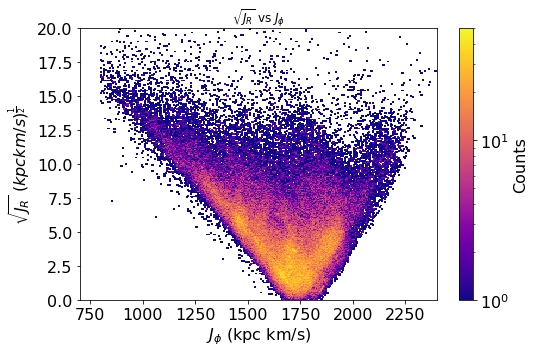

In [6]:
fig = pl.figure(figsize=(8,5))
pl.hist2d(lz*_REFR0*_REFV0, np.sqrt(jR*_REFR0*_REFV0), bins=(300,300), norm=LogNorm(), cmap='plasma', range=[[800,2500],[0,20]])
pl.title('$\sqrt{J_{R}}$ vs $J_{\phi}$')
pl.xlabel('$J_{\phi}$ (kpc km/s)')
pl.ylabel(r'$\sqrt{J_{R}}$ $(kpc km/s)^{\frac{1}{2}}$')
cbar = pl.colorbar()
cbar.ax.set_ylabel('Counts')
pl.xlim(700,2400)
pl.ylim(0,20)
pl.show

In [7]:
###############################
### SPIRAL MODEL PARAMETERS ###
###############################

CRs = 1.                    # corotation radius (put in natural units)
v_c = vcirc(pot,R=CRs)      # v_circ at corotation radius (R in [natunits])
omegas = v_c/CRs            # spiral pattern speed
m = 6                       # number of spiral arms

In [8]:
#########################################################
###############      Create Function       ##############
###############  to Obtain Radial Action   ##############
###############     from Jacobi Energy     ##############
###############   at Primary Resonances    ##############
#########################################################


from galpy.potential import epifreq

ro = _REFR0
vo = _REFV0


def getJRfromJacobienergy(m, omegas): 

    OLR = lindbladR(Pot=pot, OmegaP=omegas, m=-m, ro=ro,vo=vo) # m being negative makes this an OLR; in physical units
    ILR = lindbladR(Pot=pot, OmegaP=omegas, m=m, ro=ro,vo=vo) 
    CR = lindbladR(Pot=pot, OmegaP=omegas, m='corotation', ro=ro,vo=vo)

    pot_ILR = evaluatePotentials(pot, ILR, z=0, phi=0, ro=ro,vo=vo)
    pot_OLR = evaluatePotentials(pot, OLR, z=0, phi=0, ro=ro,vo=vo)
    pot_CR = evaluatePotentials(pot, CR, z=0, phi=0, ro=ro,vo=vo)

    kappa_ILR = epifreq(pot,R=ILR/ro,ro=ro,vo=vo)

    kappa_OLR = epifreq(pot,R=OLR/ro,ro=ro,vo=vo)

    kappa_CR = epifreq(pot,R=CR/ro,ro=ro,vo=vo)

    OmegaP = omegas*(vo/ro) #pattern speed at corotation

    v_c_ILR = vcirc(pot, R = ILR/ro, ro = ro, vo = vo) #in physical units
    OmegaP_ILR = v_c_ILR/ILR

    v_c_OLR = vcirc(pot, R = OLR/ro, ro = ro, vo = vo) #in physical units
    OmegaP_OLR = v_c_OLR/OLR

    E_c_ILR = pot_ILR + (1/2)*vcirc(pot,R=ILR/ro,ro=ro,vo=vo)**2
    E_c_OLR = pot_OLR + (1/2)*vcirc(pot,R=OLR/ro,ro=ro,vo=vo)**2
    E_c_CR = pot_CR + (1/2)*vcirc(pot,R=CR/ro,ro=ro,vo=vo)**2

    # E_J_ILR = E_c_ILR - OmegaP*ILR*vcirc(mwp,R=ILR/ro,ro=ro,vo=vo)
    # E_J_OLR = E_c_OLR - OmegaP*OLR*vcirc(mwp,R=OLR/ro,ro=ro,vo=vo)
    # E_J_CR = E_c_CR - OmegaP*CR*vcirc(mwp,R=CR/ro,ro=ro,vo=vo)

    y_intercept_ILR = OmegaP*ILR*vcirc(pot,R=ILR/ro,ro=ro,vo=vo)/kappa_ILR
    y_intercept_OLR = OmegaP*OLR*vcirc(pot,R=OLR/ro,ro=ro,vo=vo)/kappa_OLR
    y_intercept_CR = OmegaP*CR*vcirc(pot,R=CR/ro,ro=ro,vo=vo)/kappa_CR
 
    Lz = np.linspace(0,2600)

    J_R_ILR = -y_intercept_ILR + (OmegaP*Lz)/kappa_ILR
    J_R_OLR = -y_intercept_OLR + (OmegaP*Lz)/kappa_OLR
    J_R_CR = -y_intercept_CR + (OmegaP*Lz)/kappa_CR
   
    return J_R_ILR, J_R_OLR, J_R_CR

# getJRfromJacobienergy(4)[0] # This outputs J_R_ILR
# getJRfromJacobienergy(4)[1] # This outputs J_R_OLR
# getJRfromJacobienergy(4)[2] # This outputs J_R_CR

<function matplotlib.pyplot.show(close=None, block=None)>

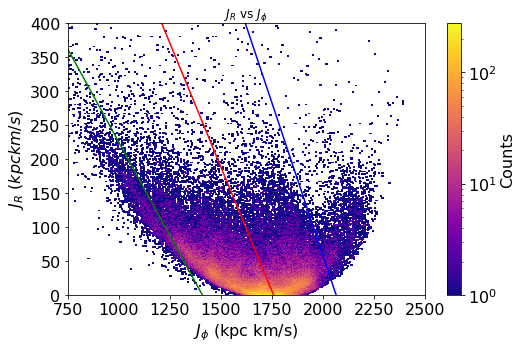

In [9]:
Lz = np.linspace(0,2600)
xmin=750
xmax=2500
ymin=0
ymax=400

fig = pl.figure(figsize=(8,5))
pl.hist2d(lz*_REFR0*_REFV0, jR*_REFR0*_REFV0, bins=(300,300), norm=LogNorm(), cmap='plasma', range=[[xmin,xmax],[ymin,ymax]])
pl.plot(Lz,-getJRfromJacobienergy(m=m, omegas=omegas)[0],color='green',ls='-',label='ILR')
pl.plot(Lz,-getJRfromJacobienergy(m=m, omegas=omegas)[1],color='blue',ls='-',label='OLR')
pl.plot(Lz,-getJRfromJacobienergy(m=m, omegas=omegas)[2],color='red',ls='-',label='CR')
pl.title('$J_{R}$ vs $J_{\phi}$')
pl.xlabel('$J_{\phi}$ (kpc km/s)')
pl.ylabel(r'$J_{R}$ $(kpc km/s)$')
cbar = pl.colorbar()
cbar.ax.set_ylabel('Counts')
pl.xlim(xmin,xmax)
pl.ylim(ymin,ymax)
pl.show